# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'oboa\\'
saveModel = 'RF_Models\\'
filename = 'oboa-e03.pkl'

X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=400, min_samples_split=11, min_samples_leaf=20, max_features='sqrt', max_depth=20, verbose=2, n_jobs=2)

In [4]:
clf.fit(X_train, y_train)
pickle.dump(clf, open(saveModel+filename, 'wb'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  8.0min


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 33.1min


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 73.1min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed: 81.1min finished


# Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  1.1min finished


Best Threshold=0.454263
Logistic: ROC AUC=0.998
Logistic: ROC AUC=0.500


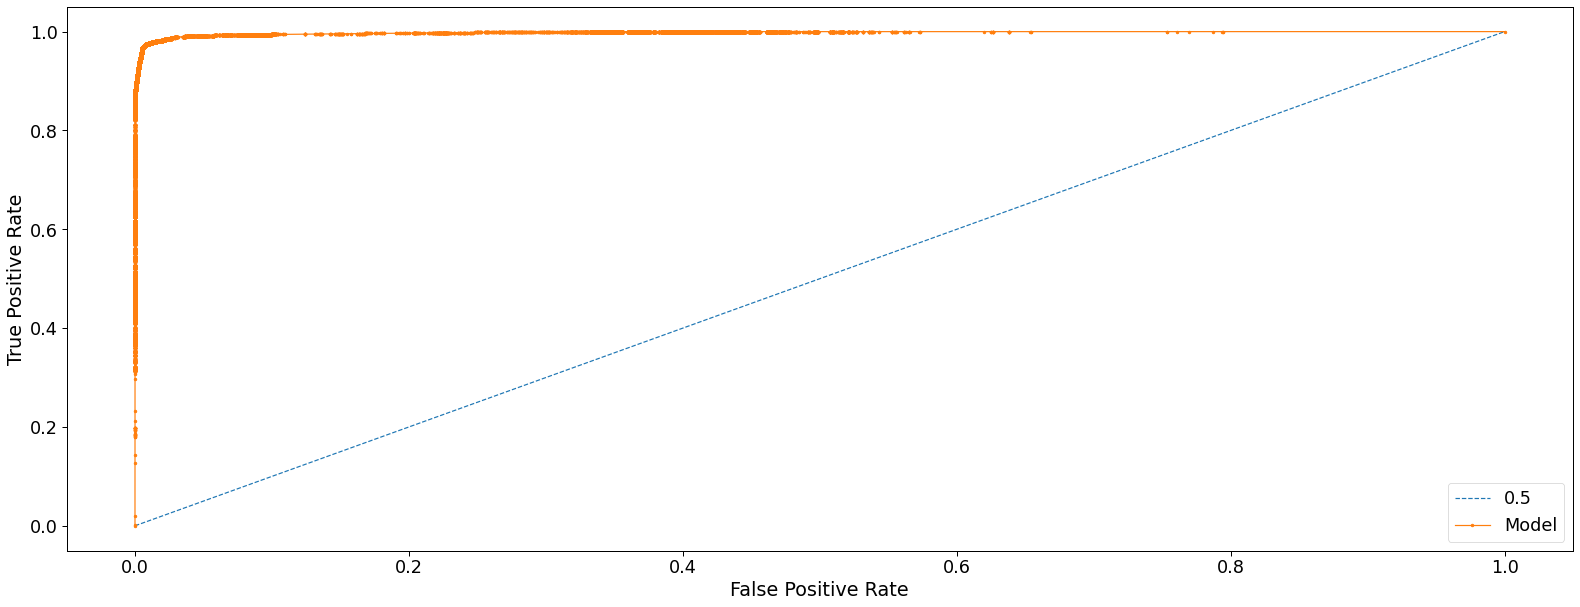

[[1267457   10798]
 [  33066 1245189]]


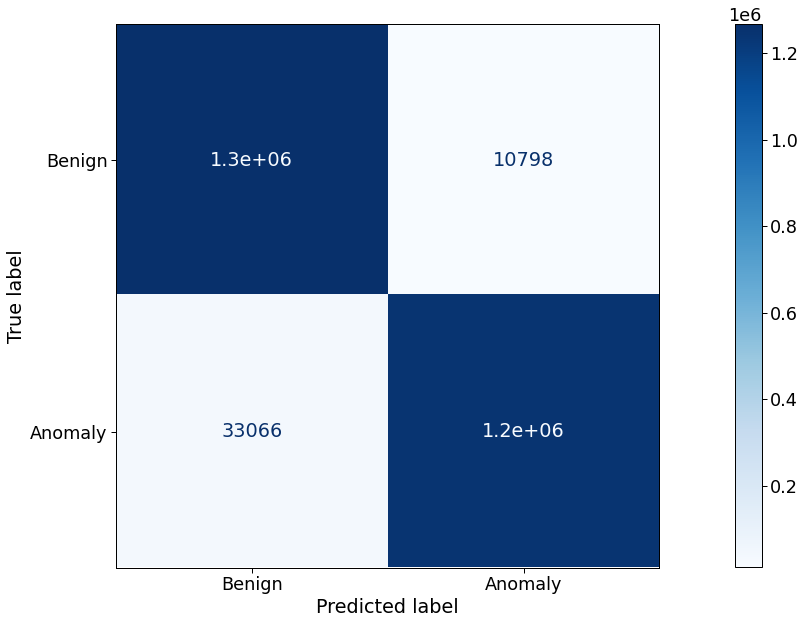

accuracy:  0.9828422341395106
f1:  0.9826914714537917
precision:  0.9914027772580448
recall:  0.9741319220343359
mcc:  0.9658310337063521


In [5]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   32.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  5.8min finished


Best Threshold=0.224131
Logistic: ROC AUC=0.734
Logistic: ROC AUC=0.500


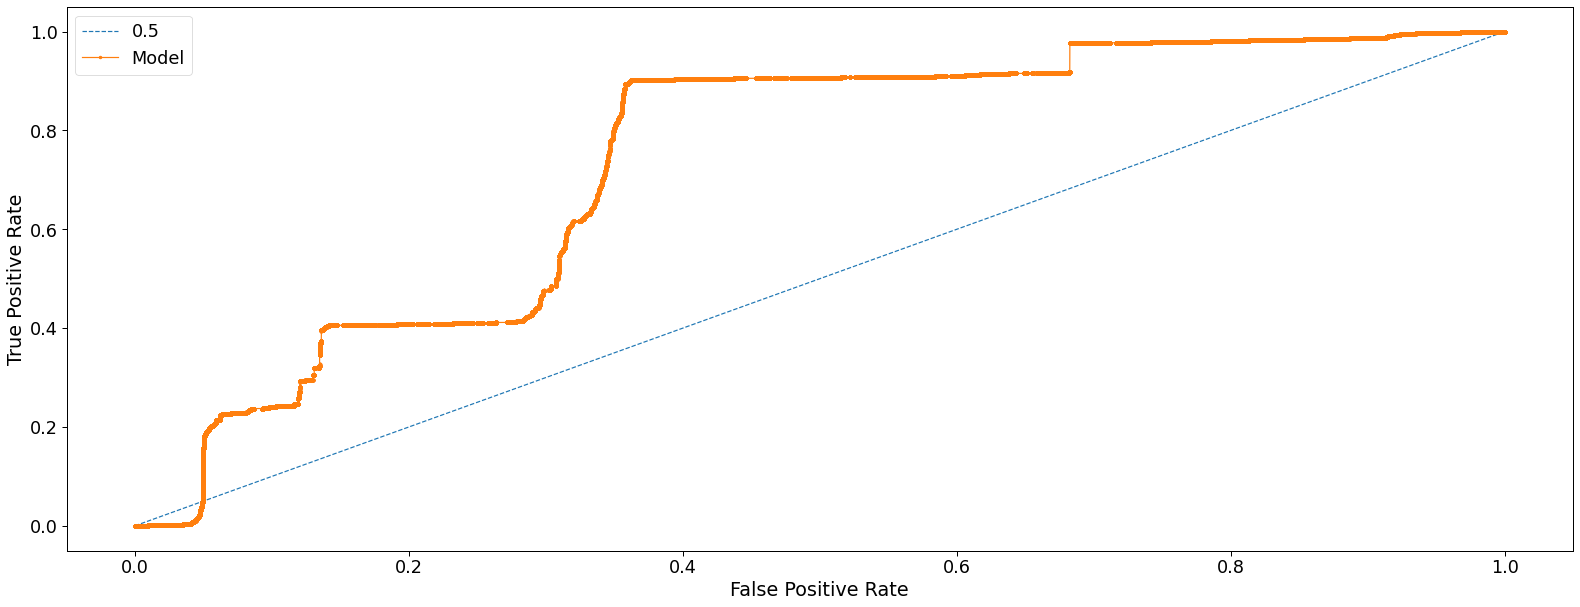

[[9690698  680048]
 [1722815  501689]]


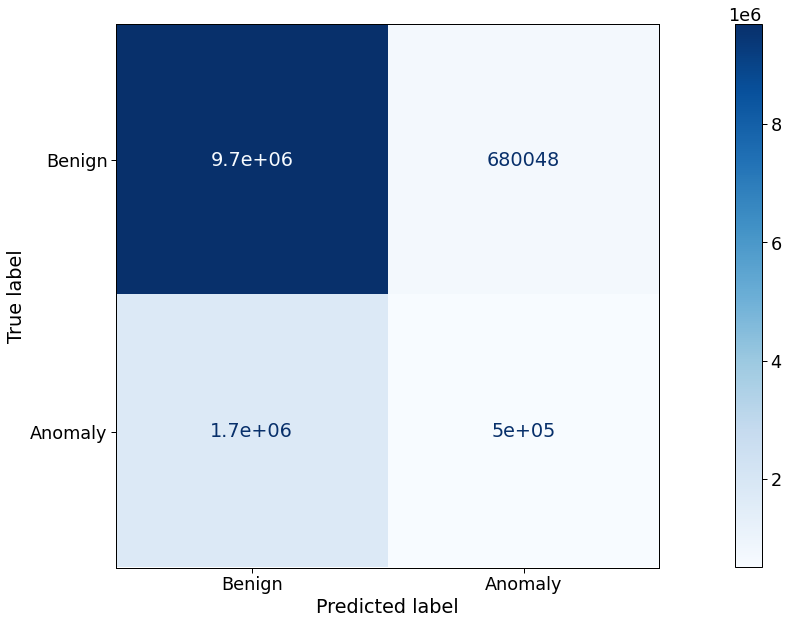

accuracy:  0.8092246680296143
f1:  0.29457046638802126
precision:  0.42453523922835623
recall:  0.2255284773594473
mcc:  0.20919378284287107
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          1                       2094
Brute Force -XSS          1                        895
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    0                          5
                          1                     280332
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  1                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      24155
                          1                       1778
Infilteration             0                      10062
                          1                     104264
SQL Injection             1                  

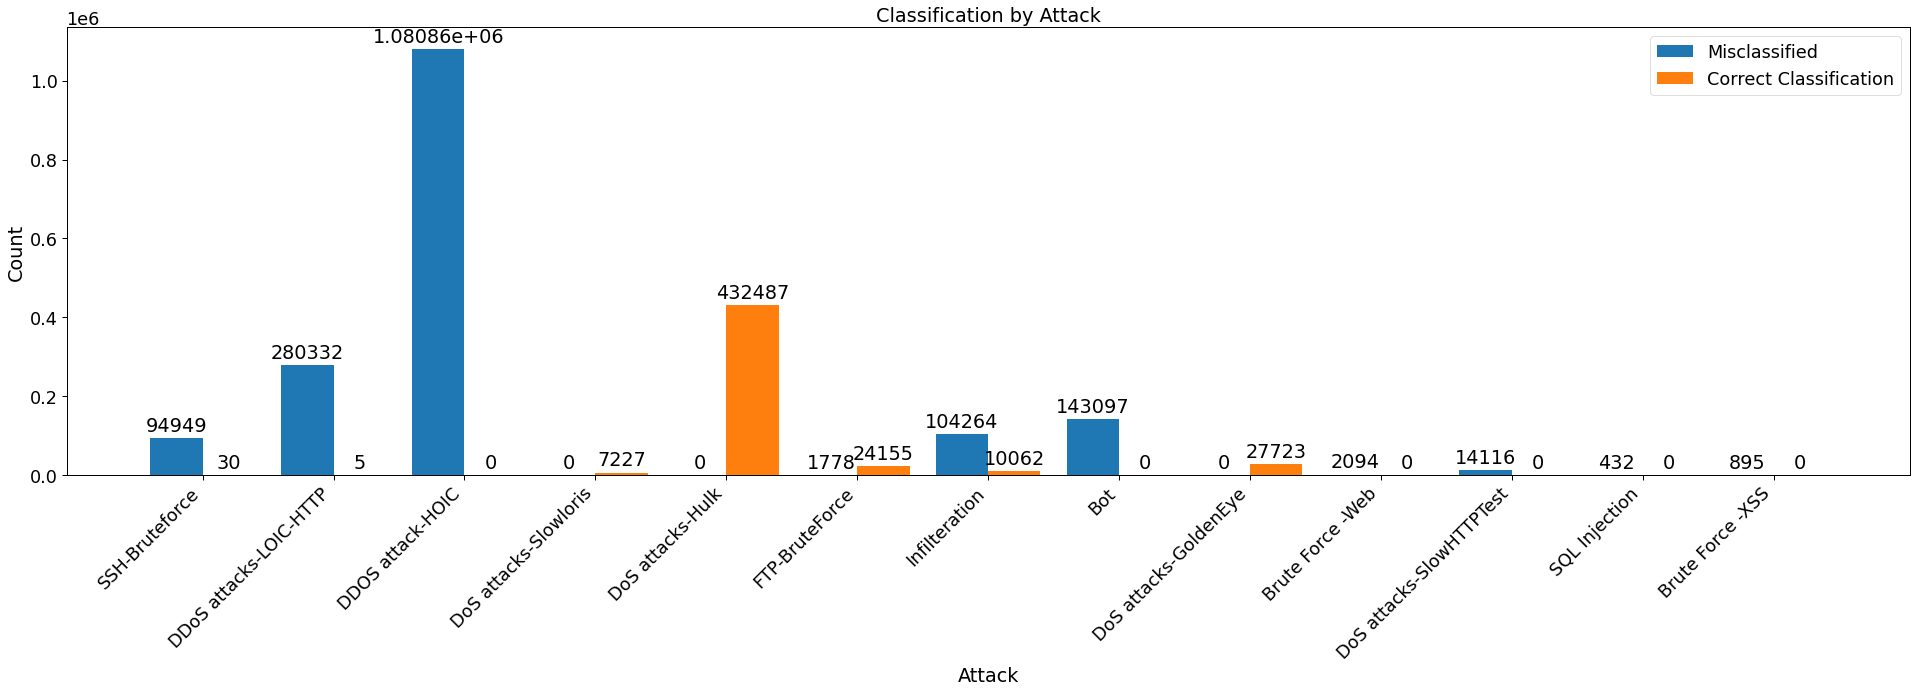

In [6]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.224131
[[6612784 3757962]
 [ 219673 2004831]]


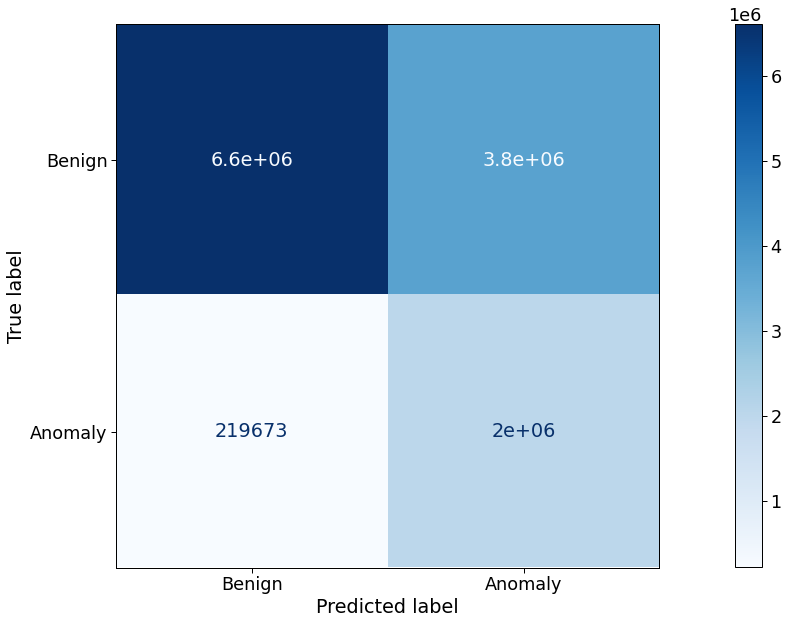

accuracy:  0.6841956293046982
f1:  0.5020048709845146
precision:  0.3478922459994659
recall:  0.9012485479909229
mcc:  0.4124906883834673
attack                    misclassification
Bot                       0                         84
                          1                     143013
Brute Force -Web          0                       2078
                          1                         16
Brute Force -XSS          0                        881
                          1                         14
DDOS attack-HOIC          0                    1080197
                          1                        661
DDoS attacks-LOIC-HTTP    0                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                     

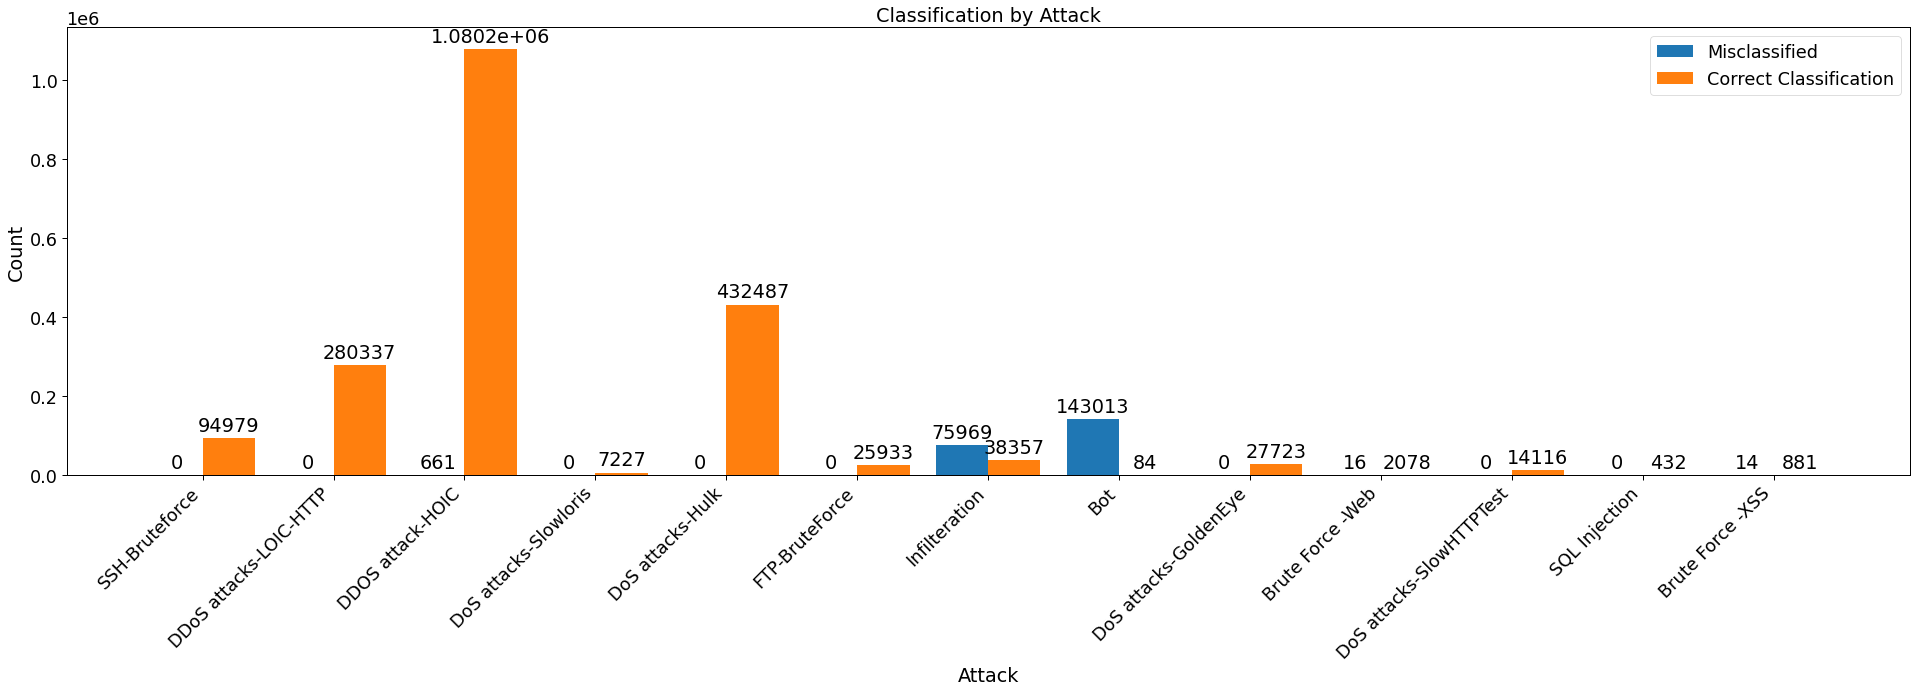

In [7]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   30.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  5.6min finished


Best Threshold=0.374612
Logistic: ROC AUC=0.858
Logistic: ROC AUC=0.500


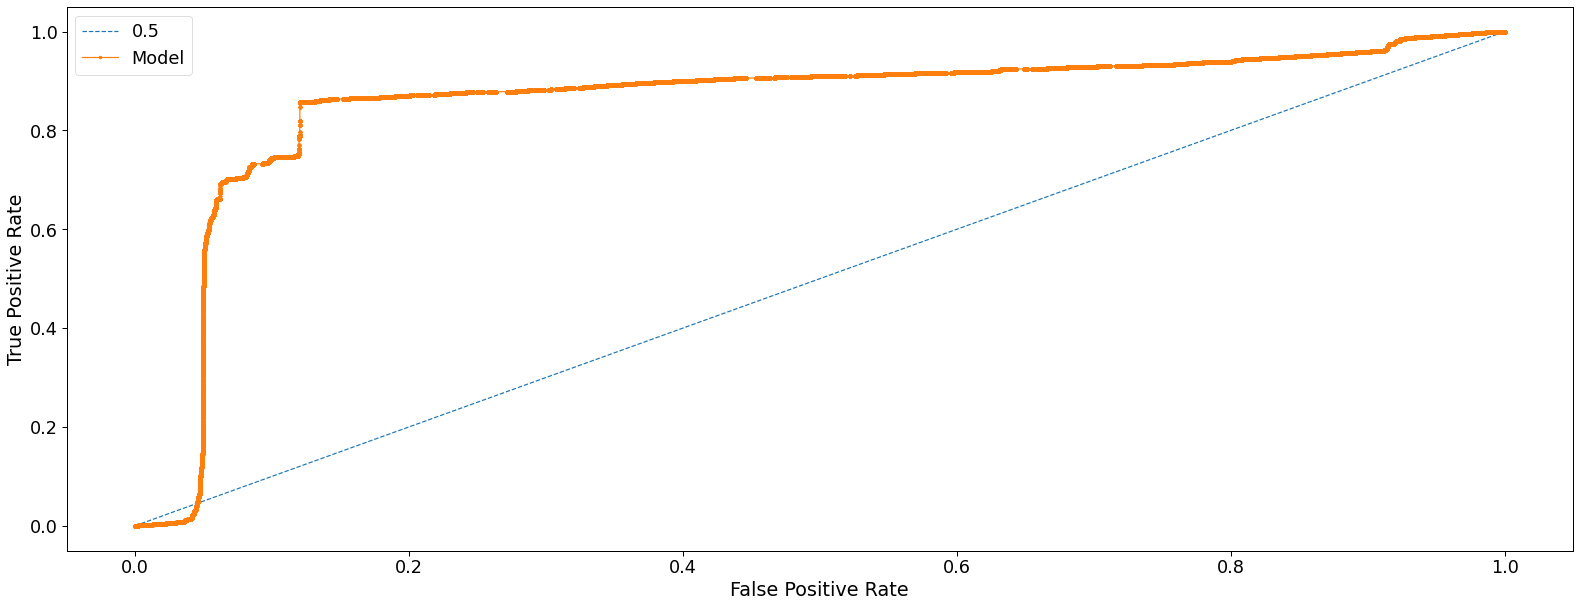

[[9690698  680048]
 [ 218528  501684]]


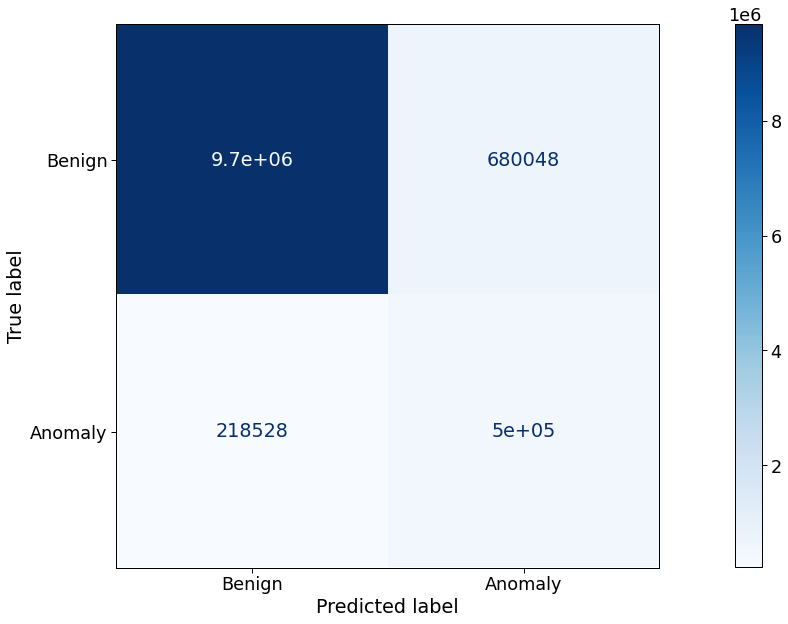

accuracy:  0.9189812097385996
f1:  0.5275486554809184
precision:  0.4245328043921972
recall:  0.6965782297434644
mcc:  0.5039509869115427
attack                    misclassification
Brute Force -Web          1                      2094
Brute Force -XSS          1                       895
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  1                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     24155
                          1                      1778
Infilteration             0                     10062
                          1                    104264
SQL Injection             1                       432
SSH-Bruteforce            0                        30
                          1                     94949
dtype: int64
[30, 94949]
[7227]
[432487]
[24155, 1778]
[10062, 104264]
[27723]
[2094]
[14116]
[432]
[895]


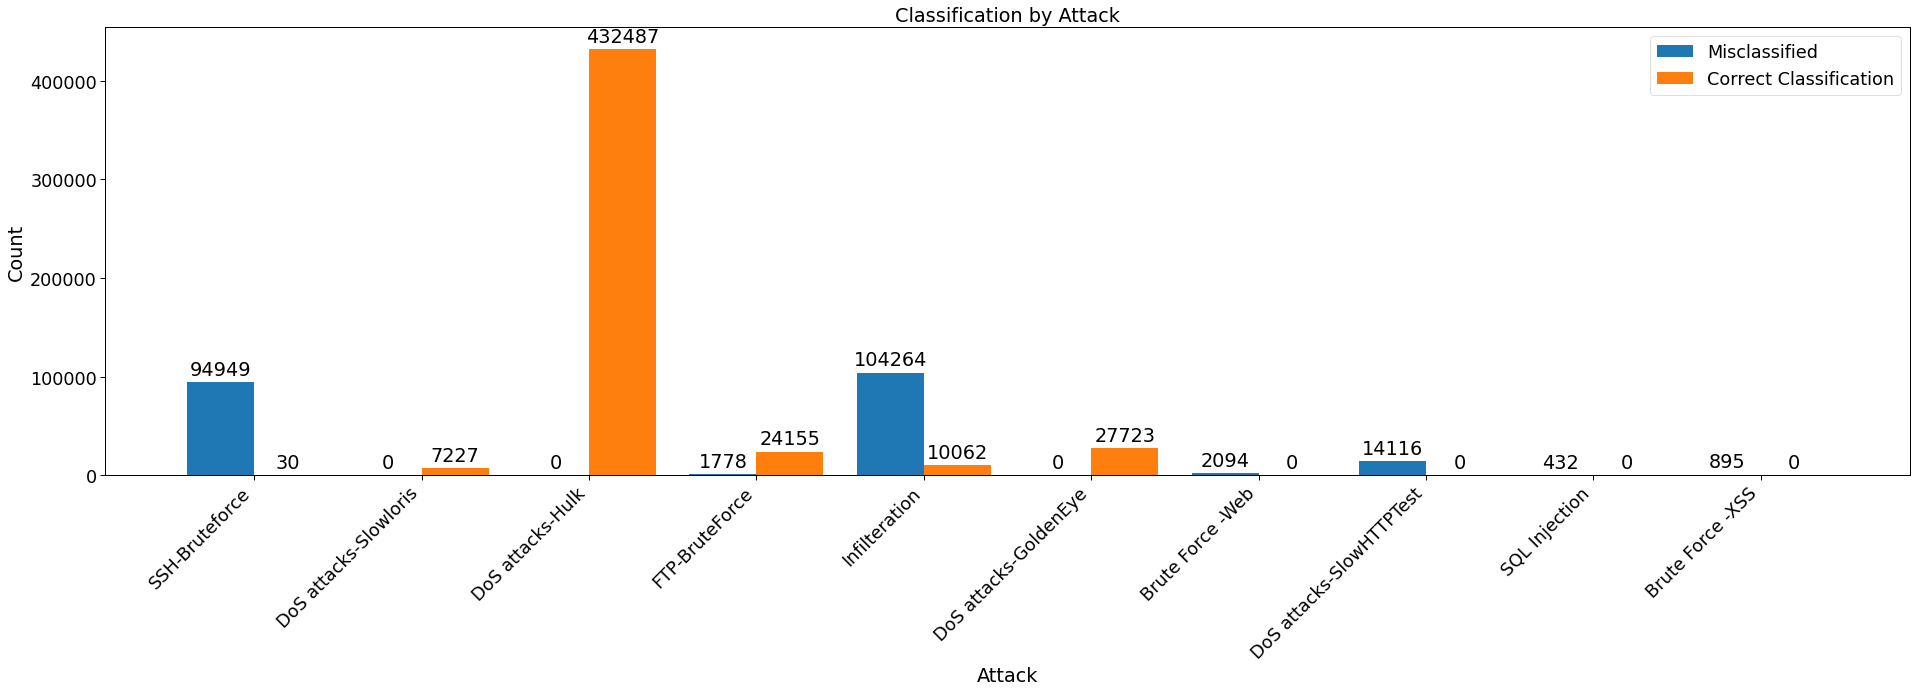

In [8]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)